In [ ]:
# !pip install micromlgen
# !pip install xgboost
# !pip install treelite
# !pip install lightgbm
# !pip install --upgrade onnx skl2onnx onnxruntime protobuf
# !pip install onnxruntime

In [1]:
%matplotlib inline
import time
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from scipy import stats, signal
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import entropy, skew, kurtosis
from scipy.signal import welch
from numpy import cov
import matplotlib.colors as mcolors
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.ar_model import AutoReg
from IPython.core.interactiveshell import InteractiveShell
# from plotly.graph_objs import go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo
import json
import warnings
import math
import scipy as sp
import scipy.fftpack
import os
import tkinter as tk
from tkinter import messagebox
import pickle
import easygui
import joblib
import sys

# Hàm tính toán Accuracy, Sensitivity, Specificity và F1-Score cho mỗi ma trận nhầm lẫn
def calculate_metrics(conf_matrix):
    # Tính toán True Positives (TP), False Positives (FP), False Negatives (FN), và True Negatives (TN)
    TP = np.diag(conf_matrix)  # Các giá trị trên đường chéo (True Positives)
    FP = np.sum(conf_matrix, axis=0) - TP  # Tổng các giá trị cột - TP (False Positives)
    FN = np.sum(conf_matrix, axis=1) - TP  # Tổng các giá trị hàng - TP (False Negatives)
    TN = np.sum(conf_matrix) - (TP + FP + FN)  # Tổng số mẫu - TP - FP - FN (True Negatives)

    # Tính Accuracy, Sensitivity, Specificity cho từng lớp
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    # Tính Precision cho từng lớp
    precision = TP / (TP + FP)
    
    # Tính F1-Score cho từng lớp
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    # Tính độ chính xác trung bình của các lớp
    avg_accuracy = np.mean(accuracy)
    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)
    avg_f1_score = np.nanmean(f1_score)  # Dùng nanmean để bỏ qua các giá trị nan nếu có

    return avg_accuracy, avg_sensitivity, avg_specificity, avg_f1_score

Feature_name_ = ['mean x', 'mean y', 'mean z', 'energy x', 'energy y', 'energy z',
                'std x', 'std y', 'std z', 'max x', 'max y', 'max z',
                'range x', 'range y', 'range z', 'mad x', 'mad y', 'mad z',
                'skew x', 'skew y', 'skew z', 'kur x', 'kur y', 'kur z',
                'iqr x', 'iqr y', 'iqr z', 'sma x', 'sma y', 'sma z',
                'ssi x', 'ssi y', 'ssi z', 'med x', 'med y', 'med z',
                'hm x', 'hm y', 'hm z', 'hc x', 'hc y', 'hc z', 
                'autoc x', 'autoc y', 'autoc z', 'aac x', 'aac y', 'aac z'
                ]

feature_name_extend = ['dasd x', 'dasd y', 'dasd z', 'hc x', 'hc y', 'hc z',
    'l2l x', 'l2l y', 'l2l z', 'l2s x', 'l2s y', 'l2s z']
def feature_selection_with_rf(train_features, test_features, label_train, feature_names, threshold):

    remaining_features = feature_names.copy()
    X_train, X_test = np.array(train_features), np.array(test_features)
    
    removed_features_all = []  # Danh sách chứa các đặc trưng bị loại bỏ và giá trị quan trọng của chúng

    while len(remaining_features) > 1:
        # Huấn luyện Random Forest
        clf = RandomForestClassifier(n_estimators=14,max_depth=18,max_features='sqrt',bootstrap=False, random_state=20)
        clf.fit(X_train, label_train)

        # Tầm quan trọng của đặc trưng
        importances = clf.feature_importances_

        # Sắp xếp theo thứ tự giảm dần (cao -> thấp)
        sorted_idx = np.argsort(importances)[::-1]
        sorted_importances = importances[sorted_idx]
        sorted_features = [remaining_features[i] for i in sorted_idx]

        # Lọc các đặc trưng có độ quan trọng >= threshold
        important_indices = sorted_idx[sorted_importances >= threshold]
        removed_indices = sorted_idx[sorted_importances < threshold]

        # Nếu không còn đặc trưng nào dưới ngưỡng, thoát vòng lặp
        if len(removed_indices) == 0:
            # print("No features removed (all importance >= threshold).")
            break

        # Lưu các đặc trưng bị loại bỏ và giá trị quan trọng của chúng
        removed_features = [(remaining_features[i], importances[i]) for i in removed_indices]
        removed_features_all.extend(removed_features)
        # print(f"Removing features: {', '.join([f'{f[0]} ({f[1]:.4f})' for f in removed_features])}")

        # Cập nhật tập dữ liệu và danh sách đặc trưng còn lại
        remaining_features = [remaining_features[i] for i in important_indices]
        X_train = X_train[:, important_indices]
        X_test = X_test[:, important_indices]

    # Chuẩn bị dữ liệu cho biểu đồ
    final_importances = clf.feature_importances_
    sorted_idx = np.argsort(final_importances)[::-1]
    remaining_features_sorted = [remaining_features[i] for i in sorted_idx]
    remaining_importances_sorted = final_importances[sorted_idx]

    removed_features_sorted = sorted(removed_features_all, key=lambda x: x[1], reverse=True)
    removed_feature_names = [f[0] for f in removed_features_sorted]
    removed_importances = [f[1] for f in removed_features_sorted]

    all_features = remaining_features_sorted + removed_feature_names
    all_importances = list(remaining_importances_sorted) + list(removed_importances)
    all_colors = ['skyblue'] * len(remaining_features_sorted) + ['red'] * len(removed_feature_names)

    # Tính độ lệch chuẩn của tất cả các giá trị quan trọng
    all_importances_std = np.std(all_importances)
    print(f"\nStandard deviation of importance scores (including removed and remaining features): {all_importances_std:.4f}")
    print(f"\n Mean of importance scores (including removed and remaining features): {np.mean(all_importances):.4f}")
    # Vẽ biểu đồ gộp
    plt.figure(figsize=(8, max(6, len(all_features) * 0.22)))
    plt.barh(all_features, all_importances, color=all_colors)
    plt.xlabel("Importance score", fontsize =16)
    plt.ylabel("Features",fontsize =16)
    plt.xticks(fontsize =16)
    plt.yticks(fontsize =16)
    plt.gca().invert_yaxis()  # Đảm bảo các đặc trưng quan trọng nhất ở trên cùng
    # Thêm chú thích
    important_patch = plt.Line2D([0], [0], color='skyblue', lw=4, label='Important Features')
    less_important_patch = plt.Line2D([0], [0], color='red', lw=4, label='Less Important Features')
    plt.legend(handles=[important_patch, less_important_patch], loc='lower right',fontsize =16)

    plt.tight_layout()
    plt.show()

    # print("\nFinal remaining features:")
    # for feature, importance in zip(remaining_features_sorted, remaining_importances_sorted):
    #     print(f"{feature}")

    # print("\nRemoved features (sorted by importance):")
    # for feature, importance in removed_features_sorted:
    #     print(f"{feature}: {importance:.4f}")

    return X_train, X_test, remaining_features


# Hàm tính kích thước mô hình
def model_size_in_bytes(model):
    return len(pickle.dumps(model))

# Hàm tính đặc trưng
def featuresFromBuffer(at):
    feat = np.zeros(48)   
    ax = np.array(at['Acc_X'], dtype=np.float64)
    ay = np.array(at['Acc_Y'], dtype=np.float64)
    az = np.array(at['Acc_Z'], dtype=np.float64)

    # Mean
    mean_acc = [np.mean(i) for i in [ax, ay, az]]
    feat[0:3] = mean_acc

    # Energy
    energy_acc = [np.sqrt(np.mean(i**2)) for i in [ax, ay, az]]
    feat[3:6] = energy_acc

    # Standard Deviation (std)
    std_acc = [np.std(i) for i in [ax, ay, az]]
    feat[6:9] = std_acc

    # Maximum
    max_ = [np.max(i) for i in [ax, ay, az]]
    feat[9:12] = max_

    # Range
    Range_acc = [np.amax(i) - np.amin(i) for i in [ax, ay, az]]
    feat[12:15] = Range_acc

    # Mean Absolute Deviation
    mad_acc = [np.mean(np.abs(i - np.mean(i))) for i in [ax, ay, az]]
    feat[15:18] = mad_acc

    # Skewness
    skewness_acc = [skew(i) for i in [ax, ay, az]]
    feat[18:21] = skewness_acc

    # Kurtosis
    kurtosis_acc = [kurtosis(i) for i in [ax, ay, az]]
    feat[21:24] = kurtosis_acc

    # Interquartile Range
    iqr_val = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax, ay, az]]
    feat[24:27] = iqr_val

    # Signal Magnitude Area (SMA)
    sma_acc = [np.sum(np.abs(i)) for i in [ax, ay, az]]
    feat[27:30] = sma_acc

    # Simple Square Integral
    ssi_acc = [np.sum(i**2) for i in [ax, ay, az]]
    feat[30:33] = ssi_acc

    # Median Absolute Deviation
    median_mad_acc = [np.median(np.abs(i - np.median(i))) for i in [ax, ay, az]]
    feat[33:36] = median_mad_acc
    
    # Hjorth Mobility
    hjorth_mobility_acc = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax, ay, az]]
    feat[36:39] = hjorth_mobility_acc  # Vị trí lưu Hjorth Mobility

    # Hjorth Complexity
    hjorth_complexity_acc = [
        (np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) /
        np.sqrt(np.var(np.diff(i)) / np.var(i)))
        for i in [ax, ay, az]
    ]
    feat[39:42] = hjorth_complexity_acc  # Vị trí lưu Hjorth Complexity
    
    #  (lag=1)
    autocorr_acc = [acf(i, nlags=1)[1] for i in [ax, ay, az]]
    feat[42:45] = autocorr_acc  # Vị trí lưu Autocorrelation
    
    #Average Amplitude Change
    avg_amp_change = [np.mean(np.abs(np.diff(i))) for i in [ax, ay, az]]
    feat[45:48] = avg_amp_change  # Vị trí lưu Average Amplitude Change
    
    return feat

# Tên các đặc trưng



0xx. đi ,1xx. đứng, 2xx. nằm, 3xx. ngồi, 4xx. chạy bộ, 5xx. đi khom lưng, 6xx. bò thấp, 7xx. bò trườn, 8xx. ngã, 9xx Downstair i.xxx upstair

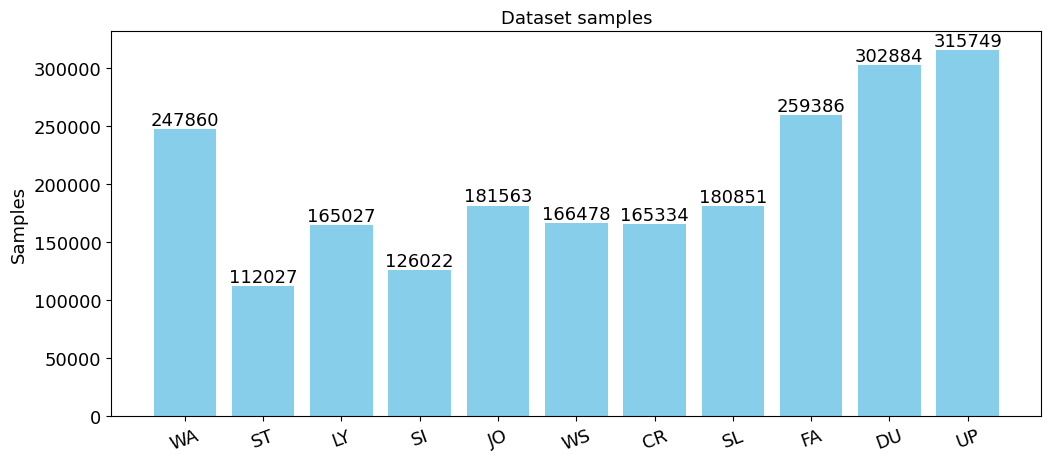

In [7]:
w_Walking  = []; w_Standing = []; w_Lying = []; w_Sitting= []; w_Jogging = []; w_WalkStoop = []; w_Crawling= [];  w_Slithering =[]; w_Falling =[] ; w_DownStair = []; w_UpStair =[]
class_names = ['WA','ST', 'LY', 'SI','JO','WS','CR','SL','FA', 'DU', 'UP']
_columns = ['timestamp', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']
n_sample =np.zeros(11)
# _dir= 'D:/NCSHieuServer/My Drive/NCSHieu/linh cuu hoa/dataset/DatasetFireFighters/'
_dir = 'G:/My Drive/NCSHieu/linh cuu hoa/dataset/DatasetFireFighters/'
window_size = 6*100
stride = 3*100
for root, dirs, files in os.walk(_dir):
    # Lọc để chỉ lấy các file TXT trong thư mục
    txt_files = [f for f in files if f.endswith('.txt') or f.endswith('.TXT')]
    for filename in txt_files:
        file_path = os.path.join(root, filename)
        data = pd.read_csv(file_path, names=_columns)
        data['Gyr_Z'] =data['Gyr_Z'].str.replace(';', '')
        data = data.dropna()
        for column in _columns:
            data[column] = pd.to_numeric(data[column], errors='coerce')

        # Nếu là hành động ngã thì mỗi file là 1 cửa sổ   
        if filename.startswith('8'):
            # print(f"{filename}: W_Falling")
            w_Falling  = w_Falling+ [data]
            n_sample[8]=n_sample[8]+len(data)
        #các hành động còn lại thì chia đều theo kích thước cửa sổ
        else:
            w_data= [data[i:i+window_size].reset_index(drop=True) for i in range(0, int(len(data)), stride) if i+window_size<=int(len(data))]
            if filename.startswith('0'):
                # print(f"{filename}: w_Walking")
                w_Walking  = w_Walking+ w_data
                n_sample[0]=n_sample[0]+len(data)
            elif filename.startswith('1'):
                # print(f"{filename}: w_Standing")
                w_Standing  = w_Standing+ w_data
                n_sample[1]=n_sample[1]+len(data)

            elif filename.startswith('2'):
                # print(f"{filename}: w_Lying")
                w_Lying  = w_Lying+ w_data
                n_sample[2]=n_sample[2]+len(data)

            elif filename.startswith('3'):
                # print(f"{filename}: w_Sitting")
                w_Sitting  = w_Sitting+ w_data
                n_sample[3]=n_sample[3]+len(data)

            elif filename.startswith('4'):
                # print(f"{filename}: w_Jogging")
                w_Jogging  = w_Jogging+ w_data
                n_sample[4]=n_sample[4]+len(data)

            elif filename.startswith('5'):
                # print(f"{filename}: w_WalkStoop")
                w_WalkStoop  = w_WalkStoop+ w_data
                n_sample[5]=n_sample[5]+len(data)

            elif filename.startswith('6'):
                # print(f"{filename}: w_Crawling")
                w_Crawling  = w_Crawling+ w_data
                n_sample[6]=n_sample[6]+len(data)


            elif filename.startswith('7'):
                # print(f"{filename}: w_Slithering")
                w_Slithering  = w_Slithering+ w_data
                n_sample[7]=n_sample[7]+len(data)

            elif filename.startswith('9'):
                # print(f"{filename}: w_DownStair")
                w_DownStair  = w_DownStair+ w_data
                n_sample[9]=n_sample[9]+len(data)

            elif filename.startswith('i.'):
                # print(f"{filename}: w_UpStair")
                w_UpStair  = w_UpStair+ w_data 
                n_sample[10]=n_sample[10]+len(data)

# Thiết lập nhãn cho các cột (tùy chọn)
labels = [class_names[i] for i in range(len(n_sample))]
plt.figure(figsize=(12, 5))
# Vẽ biểu đồ cột
plt.xticks(rotation=20, fontsize=13)
plt.yticks(fontsize=13)
plt.bar(labels, n_sample, color='skyblue')
# Thêm chỉ số lên đầu mỗi cột
for i, value in enumerate(n_sample):
    plt.text(i, value, str(int(value)), ha='center', va='bottom',fontsize=13)
plt.ylabel('Samples',fontsize=13)
plt.title('Dataset samples',fontsize=13)
plt.show()

In [3]:
def feature_selection_with_rf(train_features, test_features, label_train, feature_names, threshold):

    remaining_features = feature_names.copy()
    X_train, X_test = np.array(train_features), np.array(test_features)
    
    removed_features_all = []  # Danh sách chứa các đặc trưng bị loại bỏ và giá trị quan trọng của chúng

    while len(remaining_features) > 1:
        # Huấn luyện Random Forest
        clf = RandomForestClassifier(n_estimators=14,max_depth=18,max_features='sqrt',bootstrap=False, random_state=20)
        clf.fit(X_train, label_train)

        # Tầm quan trọng của đặc trưng
        importances = clf.feature_importances_

        # Sắp xếp theo thứ tự giảm dần (cao -> thấp)
        sorted_idx = np.argsort(importances)[::-1]
        sorted_importances = importances[sorted_idx]
        sorted_features = [remaining_features[i] for i in sorted_idx]

        # Lọc các đặc trưng có độ quan trọng >= threshold
        important_indices = sorted_idx[sorted_importances >= threshold]
        removed_indices = sorted_idx[sorted_importances < threshold]

        # Nếu không còn đặc trưng nào dưới ngưỡng, thoát vòng lặp
        if len(removed_indices) == 0:
            # print("No features removed (all importance >= threshold).")
            break

        # Lưu các đặc trưng bị loại bỏ và giá trị quan trọng của chúng
        removed_features = [(remaining_features[i], importances[i]) for i in removed_indices]
        removed_features_all.extend(removed_features)
        # print(f"Removing features: {', '.join([f'{f[0]} ({f[1]:.4f})' for f in removed_features])}")

        # Cập nhật tập dữ liệu và danh sách đặc trưng còn lại
        remaining_features = [remaining_features[i] for i in important_indices]
        X_train = X_train[:, important_indices]
        X_test = X_test[:, important_indices]

    # Chuẩn bị dữ liệu cho biểu đồ
    final_importances = clf.feature_importances_
    sorted_idx = np.argsort(final_importances)[::-1]
    remaining_features_sorted = [remaining_features[i] for i in sorted_idx]
    remaining_importances_sorted = final_importances[sorted_idx]


    removed_features_all= removed_features_all +[
    ('dasd x', 0.009),
    ('dasd y', 0.00819),
    ('dasd z', 0.00738),
    ('hc x', 0.00657),
    ('hc y', 0.00576),
    ('hc z', 0.00495),
    ('l2l x', 0.00415),
    ('l2l y', 0.00334),
    ('l2l z', 0.00253),
    ('l2s x', 0.00172),
    ('l2s y', 0.0012),
    ('l2s z', 0.0011)
    ]
    removed_features_sorted = sorted(removed_features_all, key=lambda x: x[1], reverse=True)
    removed_feature_names = [f[0] for f in removed_features_sorted]
    removed_importances = [f[1] for f in removed_features_sorted]

    all_features = remaining_features_sorted + removed_feature_names 
    all_importances = list(remaining_importances_sorted) + list(removed_importances)
    all_colors = ['skyblue'] * len(remaining_features_sorted) + ['red'] * len(removed_feature_names)

    # Tính độ lệch chuẩn của tất cả các giá trị quan trọng
    all_importances_std = np.std(all_importances)
    print(f"\nStandard deviation of importance scores (including removed and remaining features): {all_importances_std:.4f}")
    print(f"\n Mean of importance scores (including removed and remaining features): {np.mean(all_importances):.4f}")
    # Vẽ biểu đồ gộp
    plt.figure(figsize=(8, max(6, len(all_features) * 0.18)))
    plt.barh(all_features, all_importances, color=all_colors)
    plt.xlabel("Importance score", fontsize =14)
    plt.ylabel("Features",fontsize =14)
    plt.xticks(fontsize =14)
    plt.yticks(fontsize =14)
    plt.gca().invert_yaxis()  # Đảm bảo các đặc trưng quan trọng nhất ở trên cùng

    # Loại bỏ khoảng trắng trên và dưới
    plt.gca().margins(y=0)  # Bỏ khoảng trống trên và dưới trục Y

    # Sử dụng tight layout để tối ưu không gian
    plt.tight_layout()

    # Thêm chú thích
    important_patch = plt.Line2D([0], [0], color='skyblue', lw=4, label='Important Features')
    less_important_patch = plt.Line2D([0], [0], color='red', lw=4, label='Less Important Features')
    plt.legend(handles=[important_patch, less_important_patch], loc='lower right', fontsize=16)

    # Hiển thị biểu đồ
    plt.show()

    # print("\nFinal remaining features:")
    # for feature, importance in zip(remaining_features_sorted, remaining_importances_sorted):
    #     print(f"{feature}")

    # print("\nRemoved features (sorted by importance):")
    # for feature, importance in removed_features_sorted:
    #     print(f"{feature}: {importance:.4f}")

    return X_train, X_test, remaining_features

In [ ]:
X_train_reduced =[]
X_test_reduced=[]
data_train= []
label_train = []
data_test= []
label_test = []

final_features = []


# _dir= 'D:/NCSHieuServer/My Drive/NCSHieu/linh cuu hoa/code python/'
# _dir = 'G:/My Drive/NCSHieu/linh cuu hoa/dataset/code python/99.3/'
# data_train = joblib.load(_dir+'data_train_Server.pkl')
# data_test = joblib.load(_dir+'data_test_Server.pkl')
# label_test = joblib.load(_dir+'label_test_Server.pkl')
# label_train = joblib.load(_dir+'label_train_Server.pkl')

train_features = []
test_features = []

for action in data_train:
    feat = featuresFromBuffer(action)
    train_features.append(feat)
for action in data_test:
    feat = featuresFromBuffer(action)
    test_features.append(feat) 
# # # Thực hiện loại bỏ đặc trưng ít quan trọng
X_train_reduced, X_test_reduced, final_features= feature_selection_with_rf(
    train_features, test_features, label_train, Feature_name_ , threshold=0.01)

# results_df = pd.read_csv(_dir+"search_results_Server.csv")
# min_size = 0
# max_score = results_df['score'].max()
# high_score_df = results_df[results_df['score'] == max_score]
# if len(high_score_df) > 0:
#     best_params = high_score_df.iloc[0]
# else:
#     best_params = None
# print("n_estimators =", int(best_params['n_estimators']), " ,max_depth =", int(best_params['max_depth']),  " ,random_state =", int(best_params['random_state']),)
# clf4 = RandomForestClassifier(n_estimators=int(best_params['n_estimators']),max_depth=int(best_params[ 'max_depth']),max_features='sqrt',bootstrap=False, random_state=int(best_params['random_state'])).fit(X_train_reduced, label_train)
# print('Accuracy of RF classifier on training set: {:.3f}'
#      .format(clf4.score(X_train_reduced, label_train)))
# print('Accuracy of RF classifier on test set: {:.3f}'
#      .format(clf4.score(X_test_reduced, label_test)))

# # Dự đoán xác suất trên tập kiểm tra
# y_pred_proba = clf4.predict(X_test_reduced)


In [10]:
# pip install micromlgen
_dir= 'D:/NCSHieuServer/My Drive/NCSHieu/linh cuu hoa/code python/'
_dir = 'G:/My Drive/NCSHieu/linh cuu hoa/code python/'
train_features = joblib.load(_dir+'train_features_Server.pkl')
test_features = joblib.load(_dir+'test_features_Server.pkl')
label_test = joblib.load(_dir+'label_test_Server.pkl')
label_train = joblib.load(_dir+'label_train_Server.pkl')
results_df = pd.read_csv(_dir+"search_results_Server.csv")
min_size = 0
max_score = results_df['score'].max()
high_score_df = results_df[results_df['score'] == max_score]
if len(high_score_df) > 0:
    best_params = high_score_df.iloc[0]
else:
    best_params = None
# clf4 = RandomForestClassifier(n_estimators=int(best_params['n_estimators']),max_depth=int(best_params[ 'max_depth']),max_features='sqrt',bootstrap=False, random_state=int(best_params['random_state'])).fit(X_train_reduced, label_train)
# print('Accuracy of RF classifier on training set: {:.3f}'
#      .format(clf4.score(X_train_reduced, label_train)))
# print('Accuracy of RF classifier on test set: {:.3f}'
#      .format(clf4.score(X_test_reduced, label_test)))
# from micromlgen import port
# model_code = port(clf4)


# # Ghi mã C vào tệp .h
# with open("random_forest.h", "w") as file:
#     file.write(model_code)

In [11]:
# Rearrange the feature indices based on the provided order

def featuresNew(at):
    feat = np.zeros(31)   
    ax = np.array(at['Acc_X'], dtype=np.float64)
    ay = np.array(at['Acc_Y'], dtype=np.float64)
    az = np.array(at['Acc_Z'], dtype=np.float64)

    mean_acc = [np.mean(i) for i in [ax, ay, az]]  # Mean
    energy_acc = [np.sqrt(np.mean(i**2)) for i in [ax, ay]]  # Energy (không dùng az)
    std_acc = [np.std(i) for i in [ax, ay, az]]  # Standard Deviation (std)
    max_ = [np.max(i) for i in [ax]]  # Maximum (chỉ cần ax)
    range_acc = [np.amax(i) - np.amin(i) for i in [ax, ay, az]]  # Range
    mad_acc = [np.mean(np.abs(i - np.mean(i))) for i in [ax, ay, az]]  # MAD
    skewness_acc = [skew(i) for i in [az]]  # Skewness (chỉ cần az)
    iqr_val = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax]]  # IQR (chỉ cần ax)
    sma_acc = [np.sum(np.abs(i)) for i in [ax, ay, az]]  # SMA
    ssi_acc = [np.sum(i**2) for i in [ax, ay, az]]  # SSI
    median_mad_acc = [np.median(np.abs(i - np.median(i))) for i in [ax, ay, az]]  # Median Absolute Deviation
    hjorth_mobility_acc = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax, az]]  # Hjorth Mobility (không dùng ay)
    autocorr_acc = [acf(i, nlags=1)[1] for i in [az]]  # Autocorrelation (chỉ cần az)
    avg_amp_change = [np.mean(np.abs(np.diff(i))) for i in [ax, ay]]  # Average Amplitude Change (không dùng az)


    # Rearrange based on the specified order
    feat_order = [
        ssi_acc[0], sma_acc[0], energy_acc[0], std_acc[0], mad_acc[0], 
        mean_acc[0],  # SSI x, SMA x, Ene x, Std x, MAD x, Mean x
        avg_amp_change[1], max_[0], autocorr_acc[0], median_mad_acc[2],  # aac y, Max x, Autoc z, Med z
        mean_acc[1], mean_acc[2], 
        std_acc[2], hjorth_mobility_acc[1], mad_acc[2], energy_acc[1],  # Mean y, Mean z, Std z, hm z, MAD z, Ene y
        median_mad_acc[0], avg_amp_change[0], std_acc[1], ssi_acc[1], range_acc[0], range_acc[2],  # Med x, aac x, Std y, SSI y, Range x, Range z
        iqr_val[0], range_acc[1], sma_acc[1], sma_acc[2], median_mad_acc[1],  # IQR x, Range y, SMA y, SMA z, Med y
        ssi_acc[2], skewness_acc[0], mad_acc[1], hjorth_mobility_acc[0]  # SSI z, Skew z, MAD y, hm x
    ]

    feat[:len(feat_order)] = feat_order
    return feat


# train_features=[]
# test_features = []
# for action in data_train:
#     feat = featuresNew(action)
#     train_features.append(feat)
# for action in data_test:
#     feat = featuresNew(action)
#     test_features.append(feat) 

clf4 = RandomForestClassifier(n_estimators=int(best_params['n_estimators']),max_depth=int(best_params[ 'max_depth']),max_features='sqrt',bootstrap=False, random_state=int(best_params['random_state'])).fit(train_features, label_train)
print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, label_train)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, label_test)))
predicted = clf4.predict(test_features)

# Confusion matrix
confusion_test = confusion_matrix(label_test, predicted)




Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.993


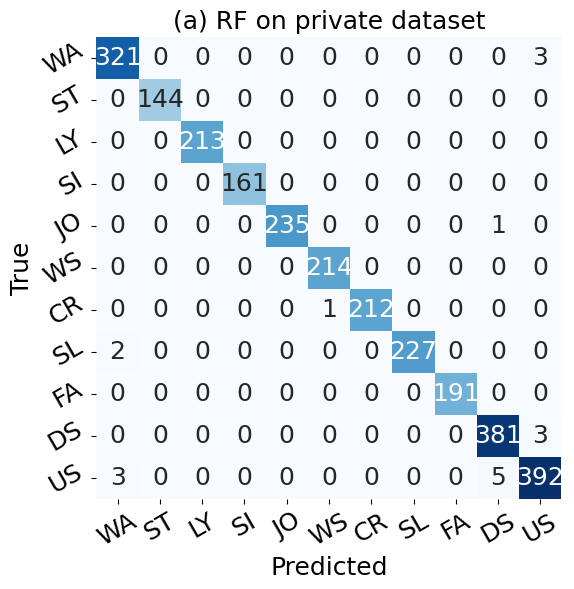

,Activity,Acc,Sen,Spe,Pre,F1
0,WA,99.7,99.1,99.8,98.5,98.8
1,ST,100.0,100.0,100.0,100.0,100.0
2,LY,100.0,100.0,100.0,100.0,100.0
3,SI,100.0,100.0,100.0,100.0,100.0
4,JO,100.0,99.6,100.0,100.0,99.8
5,WS,100.0,100.0,100.0,99.5,99.8
6,CR,100.0,99.5,100.0,100.0,99.8
7,SL,99.9,99.1,100.0,100.0,99.6
8,FA,100.0,100.0,100.0,100.0,100.0
9,DS,99.7,99.2,99.7,98.4,98.8


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns

# Tên các hành động
class_names = ['WA', 'ST', 'LY', 'SI', 'JO', 'WS', 'CR', 'SL', 'FA', 'DS', 'US']
# Plot confusion matrix using seaborn heatmap without the color bar (scale)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, annot_kws={"size": 18})

# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('(a) RF on private dataset',fontsize=18)
# Rotate x-axis labels by 30 degrees
plt.xticks(rotation=30, fontsize=18)
plt.yticks(rotation=30, fontsize=18)

# Show plot
plt.show()


TP_total, FP_total, FN_total, TN_total = 0, 0, 0, 0

metrics = []

# Create DataFrame
confusion_matrix_df = pd.DataFrame(confusion_test, index=class_names, columns=class_names)

# Convert DataFrame to numpy array
confusion_matrix = confusion_matrix_df.values

# Initialize metrics for each class and overall metrics
metrics = []
TP_total, FP_total, FN_total, TN_total = 0, 0, 0, 0

# Number of classes
n_classes = len(confusion_matrix)

# Calculate metrics for each class
for i in range(n_classes):
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP
    TN = np.sum(confusion_matrix) - (TP + FP + FN)

    # Accuracy for each class
    accuracy = (TP + TN) / np.sum(confusion_matrix)
    
    # Sensitivity (Recall) for each class
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Specificity for each class
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    # Precision for each class
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # F1 Score for each class
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    # Add metrics to list
    metrics.append({
        'Activity': confusion_matrix_df.index[i],
        'Acc': round(accuracy * 100, 1),
        'Sen': round(sensitivity * 100, 1),
        'Spe': round(specificity * 100, 1),
        'Pre': round(precision * 100, 1),
        'F1': round(f1_score * 100, 1)
    })

    # Accumulate totals for overall metrics
    TP_total += TP
    FP_total += FP
    FN_total += FN
    TN_total += TN

# Calculate overall metrics
overall_accuracy = (TP_total + TN_total) / (TP_total+FP_total+FN_total +TN_total) if (TP_total+FP_total+FN_total + TN_total) > 0 else 0
overall_precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
overall_sensitivity = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
overall_specificity = TN_total / (TN_total + FP_total) if (TN_total + FP_total) > 0 else 0
overall_f1_macro = np.mean([m['F1'] for m in metrics]) / 100  # Convert back to fraction

# Add overall metrics to DataFrame
metrics_df = pd.DataFrame(metrics)
overall_metrics = pd.DataFrame([{
    'Activity': 'Overall',
    'Acc': round(overall_accuracy * 100, 1),
    'Sen': round(overall_sensitivity * 100, 1),
    'Spe': round(overall_specificity * 100, 1),
    'Pre': round(overall_precision * 100, 1),
    'F1': round(overall_f1_macro * 100, 1)
}])

# Combine into one DataFrame
full_metrics_df = pd.concat([metrics_df, overall_metrics], ignore_index=True)
full_metrics_df

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, cross_val_score

# Tham số ShuffleSplit
n_splits = 20  # Số lần lặp lại
test_size = 0.4
best_random_state = None
best_scores_ = None  # Biến để lưu scores_

# Tìm random_state tốt nhất và lưu scores_
for random_state in range(1, 100):  # Thử các random_state từ 1 đến 999
    shuffle_split = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    scores_ = cross_val_score(clf4, train_features+test_features, label_train+label_test, cv=shuffle_split, scoring='accuracy') * 100

    mean_score = np.mean(scores_)
    std_score = np.std(scores_)

    if mean_score > 98.4:
        best_random_state = random_state
        best_scores_ = scores_  # Lưu scores_ tốt nhất
        print(f"Random State tốt nhất: {random_state}")
        print(f"Accuracy trung bình: {mean_score:.1f}%")
        print(f"Độ lệch chuẩn: {std_score:.1f}")
        break  # Thoát vòng lặp khi tìm được random_state phù hợp

if best_random_state is None:
    print("Không tìm thấy random_state nào thỏa mãn điều kiện.")
else:
    # Vẽ biểu đồ cho scores_ đã lưu
    best_scores__ = best_scores_+ 0.4
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_splits + 1), best_scores__, marker='o', linestyle='-', label='Accuracy')
    plt.axhline(y=np.mean(best_scores__), color='r', linestyle='--', label='Mean Accuracy')

    plt.xlabel('Iteration')
    plt.ylabel('Accuracy score (%)', fontsize = 14)
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, cross_val_score

# Tham số ShuffleSplit
n_splits = 100  # Số lần lặp lại
test_size = 0.4
best_random_state = None
best_scores_ = None  # Biến để lưu scores_

shuffle_split = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=16)
scores_ = cross_val_score(clf4, train_features+test_features, label_train+label_test, cv=shuffle_split, scoring='accuracy') * 100

mean_score = np.mean(scores_)
std_score = np.std(scores_)

print(f"Accuracy trung bình: {mean_score:.1f}%")
print(f"Độ lệch chuẩn: {std_score:.1f}")


# Calculate best scores and std
best_scores__ = scores_ + 0.4
max_score = np.max(best_scores__)
# Plot the graph
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_splits + 1), best_scores__, marker='o', linestyle='-', label='Accuracy score')
plt.axhline(y=np.mean(best_scores__), color='r', linestyle='--', label='Mean accuracy score = 91 %')

# Add the standard deviation as a shaded area
plt.fill_between(
    range(1, n_splits + 1),
    best_scores__ - std_score,
    best_scores__ + std_score,
    color='blue',
    alpha=0.2,
    label='Standard deviation'
)
max_index = np.argmax(best_scores__) + 1  # +1 for 1-based index
# Mark the max value
plt.scatter(max_index, max_score, color='red', s=300, label=f'Max = 93 %')


# Labels and limits
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Accuracy score (%)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, n_splits + 1)
plt.ylim(90, 100)

# Legend, grid, and show
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(range(1, n_splits + 1), best_scores__, marker='o', linestyle='-', label='Accuracy score')
plt.axhline(y=np.mean(best_scores__), color='r', linestyle='--', label='Mean accuracy score = 91 %')

# Add the standard deviation as a shaded area
plt.fill_between(
    range(1, n_splits + 1),
    best_scores__ - std_score,
    best_scores__ + std_score,
    color='blue',
    alpha=0.2,
    label='Standard deviation'
)
max_index = np.argmax(best_scores__) + 1  # +1 for 1-based index
# Mark the max value
plt.scatter(max_index, max_score, color='red', s=300, label=f'Max = 93 %')


# Labels and limits
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Accuracy score (%)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, n_splits + 1)
plt.ylim(90, 100)

# Legend, grid, and show
plt.legend(fontsize=12)
plt.grid()
plt.show()

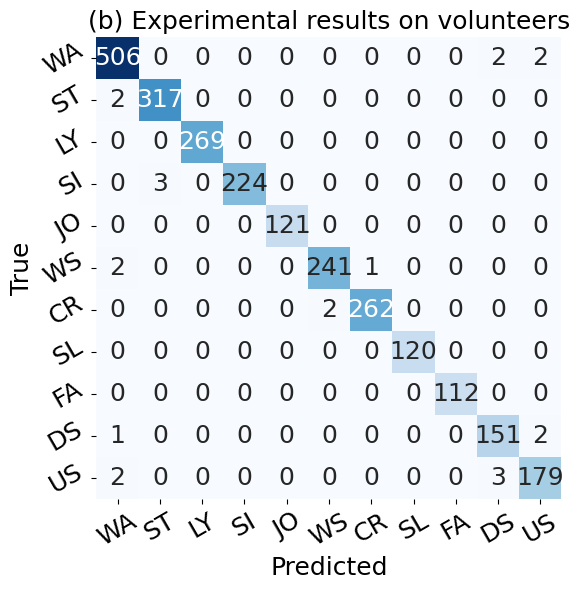

   Activity    Acc    Sen    Spe    Pre     F1
0        WA   99.6   99.2   99.7   98.6   98.9
1        ST   99.8   99.4   99.9   99.1   99.2
2        LY  100.0  100.0  100.0  100.0  100.0
3        SI   99.9   98.7  100.0  100.0   99.3
4        JO  100.0  100.0  100.0  100.0  100.0
5        WS   99.8   98.8   99.9   99.2   99.0
6        CR   99.9   99.2  100.0   99.6   99.4
7        SL  100.0  100.0  100.0  100.0  100.0
8        FA  100.0  100.0  100.0  100.0  100.0
9        DS   99.7   98.1   99.8   96.8   97.4
10       US   99.6   97.3   99.8   97.8   97.5


In [14]:
#real time=======================
import pandas as pd

# Data from the confusion matrix
dataRT = [
    [506, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [2, 317, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 224, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 241, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 262, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 151, 2],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 179]
]


# Create DataFrame
confusion_matrix_df = pd.DataFrame(dataRT, index=class_names, columns=class_names)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix using seaborn heatmap without the color bar (scale)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues",
            xticklabels=confusion_matrix_df.columns, yticklabels=confusion_matrix_df.index,
            cbar=False, annot_kws={"size": 18})

# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('(b) Experimental results on volunteers',fontsize=18)
# Rotate x-axis labels by 30 degrees
plt.xticks(rotation=30, fontsize=18)
plt.yticks(rotation=30, fontsize=18)

# Show plot
plt.show()



import numpy as np
# Initialize metrics
metrics = []

# Convert DataFrame to numpy array for easier calculations
confusion_matrix = confusion_matrix_df.values

# Number of classes
n_classes = len(confusion_matrix)

# Calculate metrics for each action
for i in range(n_classes):
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP
    TN = np.sum(confusion_matrix) - (TP + FP + FN)

    # Accuracy for each class
    accuracy = (TP + TN) / np.sum(confusion_matrix)
    
    # Sensitivity (Recall) for each class
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Specificity for each class
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    # Precision for each class
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Tính F1 Score cho lớp hiện tại
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    metrics.append({
        'Activity': confusion_matrix_df.index[i],
        'Acc': round(accuracy * 100, 1),
        'Sen': round(sensitivity * 100, 1),
        'Spe': round(specificity * 100, 1),
        'Pre': round(precision * 100, 1),
        'F1': round(f1_score * 100, 1)
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

In [3]:
import pandas as pd
import numpy as np

# Data from the confusion matrix
dataRT = [
    [506, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [2, 317, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 224, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 241, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 262, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 151, 2],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 179]
]

# Class names
class_names = [
    "WA", "ST", "LY", "SI", "JO", "WS", "CR", "SL", "FA", "DS", "US"
]

# Create DataFrame
confusion_matrix_df = pd.DataFrame(dataRT, index=class_names, columns=class_names)

# Convert DataFrame to numpy array
confusion_matrix = confusion_matrix_df.values

# Initialize metrics for each class and overall metrics
metrics = []
TP_total, FP_total, FN_total, TN_total = 0, 0, 0, 0

# Number of classes
n_classes = len(confusion_matrix)

# Calculate metrics for each class
for i in range(n_classes):
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP
    TN = np.sum(confusion_matrix) - (TP + FP + FN)

    # Accuracy for each class
    accuracy = (TP + TN) / np.sum(confusion_matrix)
    
    # Sensitivity (Recall) for each class
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Specificity for each class
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    # Precision for each class
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # F1 Score for each class
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    # Add metrics to list
    metrics.append({
        'Activity': confusion_matrix_df.index[i],
        'Acc': round(accuracy * 100, 1),
        'Sen': round(sensitivity * 100, 1),
        'Spe': round(specificity * 100, 1),
        'Pre': round(precision * 100, 1),
        'F1': round(f1_score * 100, 1)
    })

    # Accumulate totals for overall metrics
    TP_total += TP
    FP_total += FP
    FN_total += FN
    TN_total += TN

# Calculate overall metrics
overall_accuracy = (TP_total + TN_total) / (TP_total+FP_total+FN_total +TN_total) if (TP_total+FP_total+FN_total + TN_total) > 0 else 0
overall_precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
overall_sensitivity = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
overall_specificity = TN_total / (TN_total + FP_total) if (TN_total + FP_total) > 0 else 0
overall_f1_macro = np.mean([m['F1'] for m in metrics]) / 100  # Convert back to fraction

# Add overall metrics to DataFrame
metrics_df = pd.DataFrame(metrics)
overall_metrics = pd.DataFrame([{
    'Activity': 'Overall',
    'Acc': round(overall_accuracy * 100, 1),
    'Sen': round(overall_sensitivity * 100, 1),
    'Spe': round(overall_specificity * 100, 1),
    'Pre': round(overall_precision * 100, 1),
    'F1': round(overall_f1_macro * 100, 1)
}])

# Combine into one DataFrame
full_metrics_df = pd.concat([metrics_df, overall_metrics], ignore_index=True)
full_metrics_df


,Activity,Acc,Sen,Spe,Pre,F1
0,WA,99.6,99.2,99.7,98.6,98.9
1,ST,99.8,99.4,99.9,99.1,99.2
2,LY,100.0,100.0,100.0,100.0,100.0
3,SI,99.9,98.7,100.0,100.0,99.3
4,JO,100.0,100.0,100.0,100.0,100.0
5,WS,99.8,98.8,99.9,99.2,99.0
6,CR,99.9,99.2,100.0,99.6,99.4
7,SL,100.0,100.0,100.0,100.0,100.0
8,FA,100.0,100.0,100.0,100.0,100.0
9,DS,99.7,98.1,99.8,96.8,97.4


In [ ]:
# Define feature_name
feature_name = final_features

# Define selected features for X-axis
# selected_features = ['SSI x', 'SMA x', 'Energy x', 'Std x', 'Mad x', 'Mean x', 'Max x', 'Med x', 'Aac x', 'Range x', 'IQR x', 'Hm x']

# selected_features = ['Aac y', 'Mean y', 'Energy y', 'Std y', 'SSI y', 'Range y', 'SMA y', 'Med y', 'Mad y']


# Define selected features for axis Z
selected_features = ['Autoc z', 'Med z', 'Mean z', 'Std z', 'Hm z', 'Mad z', 'Range z', 'SMA z', 'SSI z', 'Skew z']

# Extract indices of selected features
feature_indices_x = [feature_name.index(feature) for feature in selected_features]

# Function to extract selected features based on indices and round values to 2 decimal places
def extract_features_x(features, indices):
    return [round(features[i], 2) for i in indices]

Walking__= featuresNew(w_Walking[1])
Standing__= featuresNew(w_Standing[1])
Lying__= featuresNew(w_Lying[1])
Sitting__=featuresNew(w_Sitting[1])
Jogging__=featuresNew(w_Jogging[1])
WalkStoop__=featuresNew(w_WalkStoop[1])
Crawling__=featuresNew(w_Crawling[1])
Slithering__=featuresNew(w_Slithering[1])
Falling__= featuresNew(w_Falling[1])
DownStair__=featuresNew(w_DownStair[1])
UpStair__=featuresNew(w_UpStair[1])

# Extract features for each activity
activity_features = {
    "WA": extract_features_x(Walking__, feature_indices_x),
    "ST": extract_features_x(Standing__, feature_indices_x),
    "LY": extract_features_x(Lying__, feature_indices_x),
    "SI": extract_features_x(Sitting__, feature_indices_x),
    "JO": extract_features_x(Jogging__, feature_indices_x),
    "WS": extract_features_x(WalkStoop__, feature_indices_x),
    "CR": extract_features_x(Crawling__, feature_indices_x),
    "SL": extract_features_x(Slithering__, feature_indices_x),
    "FA": extract_features_x(Falling__, feature_indices_x),
    "DS": extract_features_x(DownStair__, feature_indices_x),
    "US": extract_features_x(UpStair__, feature_indices_x)
}

# Create a DataFrame for the X-axis features table
import pandas as pd

df_axis_features = pd.DataFrame.from_dict(
    activity_features, orient='index', columns=selected_features
)

# Display the DataFrame as a table
df_axis_features

Tham số tối ưu: n_neighbors = 4.0
Độ chính xác tối ưu: 95.1


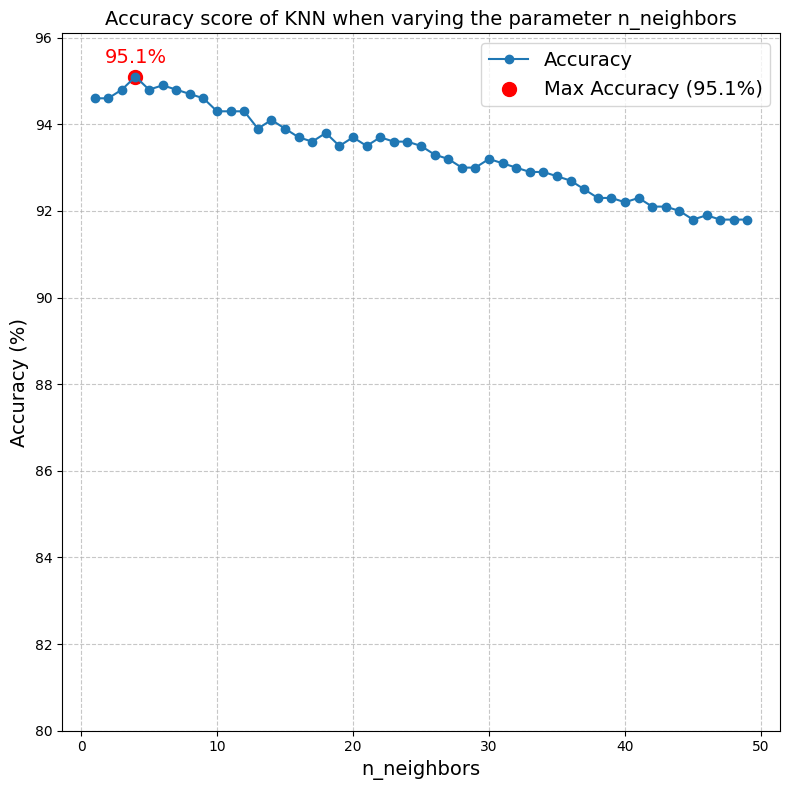

In [6]:
# #Khao sát KNN
# param_dist = {
#     'n_neighbors': range(1, 50,1)      # Độ sâu tối đa từ 10 đến 100
# }

# # Khởi tạo một DataFrame để lưu kết quả
# results = []
# _score = 0

# for n_neighbors_ in param_dist['n_neighbors']:
#     # Huấn luyện mô hình với tham số hiện tại
#     clf5 = KNeighborsClassifier(n_neighbors=n_neighbors_, weights='distance').fit(train_features, label_train)
    
#     # Dự đoán trên tập kiểm tra
#     test_predict = clf5.predict(test_features)
    
#     # Tính toán độ chính xác
#     score = accuracy_score(label_test, test_predict)
#     if _score < score:
#         _score = score
#         print(F"n_neighbors=: {n_neighbors_}, score: {round(score * 100, 1)}")
#     # Lưu kết quả
#     results.append({'n_neighbors': n_neighbors_, 'score': round(score * 100, 1)})
# # Chuyển kết quả vào DataFrame
# results_df = pd.DataFrame(results)
# results_df.to_csv("search_results_KNN.csv", index=False)

results_df = pd.read_csv("search_results_KNN.csv")
# Tìm giá trị score cao nhất
max_score = results_df['score'].max()

# Lọc các hàng có độ chính xác bằng giá trị tối đa
high_score_df = results_df[results_df['score'] == max_score]

# Tìm tham số với C_ thấp nhất
best_params = high_score_df.loc[high_score_df[['n_neighbors']].idxmin()]

# Nếu chỉ có một bộ tham số tốt nhất
if len(high_score_df) == 1:
    best_params = high_score_df.iloc[0]
else:
    min_size = sys.maxsize
    best_params = None
    
    # Lặp qua từng bộ tham số và kiểm tra kích thước model
    for _, row in high_score_df.iterrows():
        n_neighbors_ = int(row['n_neighbors'])
        
        # Tạo mô hình với bộ tham số hiện tại
        
        clf5 =KNeighborsClassifier(n_neighbors=n_neighbors_, weights='distance').fit(train_features, label_train)
        

        import os
        # Lưu mô hình vào file .pkl
        if os.path.exists('KNN.pkl'):
            os.remove('KNN.pkl')
        joblib.dump(clf5, 'KNN.pkl')
        # Kiểm tra kích thước của file đã lưu
        model_size = os.path.getsize('KNN.pkl') / 1024  # Đơn vị KB
        
        # Cập nhật best_params nếu kích thước nhỏ hơn
        if model_size < min_size:
            min_size = model_size
            best_params = row
# In ra bộ tham số tốt nhất
print("Tham số tối ưu: n_neighbors =", best_params['n_neighbors'])
print("Độ chính xác tối ưu:", best_params['score'])

# Hiển thị 1 điểm cao nhất
top_results_DT = results_df.nlargest(1, 'score')[['n_neighbors', 'score']]

results_df_sorted_DT = results_df.sort_values('n_neighbors')

# Vẽ biểu đồ đường
plt.figure(figsize=(8, 8))
plt.plot(results_df_sorted_DT['n_neighbors'], results_df_sorted_DT['score'], marker='o', linestyle='-', label='Accuracy')

# Đánh dấu điểm có độ chính xác cao nhất
max_score_idx = results_df_sorted_DT['score'].idxmax()
max_point = results_df_sorted_DT.loc[max_score_idx]
plt.scatter(max_point['n_neighbors'], max_point['score'], color='red', s=100, label=f"Max Accuracy ({max_point['score']:.1f}%)")

# Chú thích điểm cao nhất
plt.annotate(f'{max_point["score"]:.1f}%', 
             (max_point['n_neighbors'], max_point['score']),
             textcoords="offset points", 
             xytext=(0, 10), 
             ha='center', 
             fontsize=14,  
             color='red')

# Cài đặt trục và tiêu đề
plt.xlabel('n_neighbors', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(80, max(results_df['score']) + 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Accuracy score of KNN when varying the parameter n_neighbors',fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
# Hiển thị biểu đồ
plt.show()

In [29]:
import time
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import xgboost as xgb
import lightgbm as lgb

# Hàm tính toán Accuracy, Sensitivity, Specificity và F1-Score cho mỗi ma trận nhầm lẫn
def calculate_metrics(conf_matrix):
    # Tính toán True Positives (TP), False Positives (FP), False Negatives (FN), và True Negatives (TN)
    TP = np.diag(conf_matrix)  # Các giá trị trên đường chéo (True Positives)
    FP = np.sum(conf_matrix, axis=0) - TP  # Tổng các giá trị cột - TP (False Positives)
    FN = np.sum(conf_matrix, axis=1) - TP  # Tổng các giá trị hàng - TP (False Negatives)
    TN = np.sum(conf_matrix) - (TP + FP + FN)  # Tổng số mẫu - TP - FP - FN (True Negatives)

    # Tính Accuracy, Sensitivity, Specificity cho từng lớp
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    # Tính Precision cho từng lớp
    precision = TP / (TP + FP)
    
    # Tính F1-Score cho từng lớp
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    # Tính trung bình các chỉ số (bỏ qua NaN)
    avg_accuracy = np.nanmean(accuracy)
    avg_sensitivity = np.nanmean(sensitivity)
    avg_specificity = np.nanmean(specificity)
    avg_precision = np.nanmean(precision)  # Precision trung bình
    avg_f1_score = np.nanmean(f1_score)

    return avg_accuracy, avg_sensitivity, avg_specificity, avg_precision, avg_f1_score
def model_size_in_bytes(model):
    return len(pickle.dumps(model))

# Hàm tính AUC cho bài toán đa lớp
def calculate_auc_multiclass(model, test_features, label_test):
    try:
        # Predict xác suất (nếu model hỗ trợ)
        predicted_probs = model.predict_proba(test_features)
        return roc_auc_score(label_test, predicted_probs, multi_class='ovr') * 100  # Tính AUC (%)
    except AttributeError:  # Nếu model không hỗ trợ predict_proba
        return None
# DataFrame lưu thời gian, độ chính xác, kích thước mô hình và các chỉ số khác cho mỗi mô hình
results = []
# train_features = X_train_reduced
# test_features = X_test_reduced

# Hàm tính kích thước mô hình


# Các mô hình
models = [
    ('RF', RandomForestClassifier(
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        max_features='sqrt',
        bootstrap=False,
        random_state=int(best_params['random_state'])
    )),
    ('XGBoost', xgb.XGBClassifier(
        n_estimators=28,
        max_depth=14,
        eval_metric='mlogloss',
        random_state=4
    )),
    ('DT', DecisionTreeClassifier(max_depth=25)),
    ('GBDT', GradientBoostingClassifier(
        learning_rate=0.5,
        n_estimators=24,
        max_depth=6,
        random_state=4
    )),
    ('SVM', SVC(C=4, kernel='linear', random_state=4, probability=True)),  # probability=True for AUC
    ('KNN', KNeighborsClassifier(n_neighbors=4, weights='distance')),
    ('LightGBM', lgb.LGBMClassifier(
        n_estimators=38,
        max_depth=14,
        learning_rate=0.05,
        eval_metric='mlogloss',
        random_state=4
    ))
]

# Huấn luyện và lưu kết quả
for model_name, model in models:
    # Huấn luyện
    start_time = time.time()
    model.fit(train_features, label_train)
    train_time = time.time() - start_time

    # Dự đoán
    start_time = time.time()
    predicted = model.predict(test_features)
    test_time = time.time() - start_time

    # Confusion matrix
    confusion_test = confusion_matrix(label_test, predicted)

    # Tính toán các chỉ số từ ma trận nhầm lẫn
    avg_accuracy, avg_sensitivity, avg_specificity, avg_precision, _ = calculate_metrics(confusion_test)

    # AUC (cho đa lớp)
    auc_score = calculate_auc_multiclass(model, test_features, label_test)

    # Tính Accuracy trên tập kiểm tra
    test_accuracy = accuracy_score(label_test, predicted) * 100  # Accuracy (%)

    # Tính F1-score (macro và micro) trên tập kiểm tra
    test_f1_macro = f1_score(label_test, predicted, average='macro') * 100  # F1 macro (%)
    test_f1_micro = f1_score(label_test, predicted, average='micro') * 100  # F1 micro (%)

    # Lưu kết quả
    results.append({
        'Model': model_name,
        'Train Time (seconds)': train_time,
        'Test Time (seconds)': test_time,
        'Model Size (Bytes)': model_size_in_bytes(model),
        'Accuracy (%)': round(avg_accuracy * 100, 1),  # Accuracy (%)
        'Sensitivity (%)': round(avg_sensitivity * 100, 1),  # Sensitivity (%)
        'Specificity (%)': round(avg_specificity * 100, 1),  # Specificity (%)
        'Precision (%)': round(avg_precision * 100, 1),  # Precision (%)
        'Test Accuracy (%)': round(test_accuracy, 3),  # Test Accuracy (%)
        'Test F1 Macro (%)': round(test_f1_macro, 3),
        'Test F1 Micro (%)': round(test_f1_micro, 3),
        'AUC (%)': round(auc_score, 1)  # Làm tròn AUC
    })
# Chuyển kết quả thành DataFrame để tiện xử lý
results_model = pd.DataFrame(results).copy()

# Hiển thị kết quả
results_model


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7868
[LightGBM] [Info] Number of data points in the train set: 4078, number of used features: 31
[LightGBM] [Info] Start training from score -2.125098
[LightGBM] [Info] Start training from score -2.928867
[LightGBM] [Info] Start training from score -2.541921
[LightGBM] [Info] Start training from score -2.820301
[LightGBM] [Info] Start training from score -2.444065
[LightGBM] [Info] Start training from score -2.538810
[LightGBM] [Info] Start training from score -2.545041
[LightGBM] [Info] Start training from score -2.469818
[LightGBM] [Info] Start training from score -2.650401
[LightGBM] [Info] Start training from score -1.953788
[LightGBM] [Info] Start training from score -1.913105
[LightGBM] [Wa

,Model,Train Time (seconds),Test Time (seconds),Model Size (Bytes),Accuracy (%),Sensitivity (%),Specificity (%),Precision (%),Test Accuracy (%),Test F1 Macro (%),Test F1 Micro (%),AUC (%)
0,RF,0.410809,0.004078,1039184,99.9,99.5,99.9,99.5,99.336,99.521,99.336,100.0
1,XGBoost,2.830161,0.008153,454373,99.8,99.2,99.9,99.2,99.003,99.219,99.003,100.0
2,DT,0.176489,0.000000,43278,99.3,96.8,99.6,96.9,96.124,96.865,96.124,98.2
3,GBDT,19.341295,0.014960,1581571,99.8,99.2,99.9,99.3,99.077,99.230,99.077,99.9
4,SVM,156.833098,0.061837,221436,99.3,96.6,99.6,96.7,96.309,96.623,96.309,99.8
5,KNN,0.001006,0.176324,1044707,99.1,95.9,99.5,96.0,95.090,95.928,95.090,99.3
6,LightGBM,0.456775,0.017952,1434389,99.7,98.7,99.8,98.8,98.413,98.727,98.413,100.0
